In [ ]:
print("EDA - MINOR Project")

EDA - MINOR Project


In [23]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from scipy import stats

# 2. Entity Relationship Mapping

## Target Star Schema

| FactSales        | DimCustomer | DimMedicine | DimShop      | DimPrescription | DimPurchase | FactStockSnapshot |
|------------------|-------------|-------------|--------------|-----------------|-------------|-------------------|
| sale_id          | customer_id | medicine_id | shop_id      | prescription_id | purchase_id | stock_id          |
| sale_date        | age         | medicine_name| location     | doctor_name     | supplier_name| last_updated      |
| customer_id      | city        | type_id     | manager_name | date            | purchase_date| available_units   |
| medicine_id      | contact flags| type_name   | rating       | dosage          | cost_price   |                   |
| shop_id          |             | category    |              |                 |             |                   |
| prescription_id  |             | brand       |              |                 |             |                   |
| quantity         |             | price       |              |                 |             |                   |
| discount         |             |             |              |                 |             |                   |
| final_price      |             |             |              |                 |             |                   |
| payment_mode     |             |             |              |                 |             |                   |
| status           |             |             |              |                 |             |                   |

**Entity Relationships:**
- SalesBills.customer_id → Customers
- SalesBills.medicine_id → Medicines
- SalesBills.shop_id → PharmacyShops
- SalesBills.prescription_id → Prescriptions
- Medicines.type_id → TypesOfMedicines
- Purchases.(medicine_id,shop_id) → (Medicines,PharmacyShops)

Below, we load all data and map DataFrames to schema entities.

### Importing all the data in to DataFrame

In [24]:
customers = pd.read_csv('data/Customers.csv')
customers.head()

,customer_id,full_name,email,phone,city,age
0,CUST1000,Ishita Shah,suresh.khan426@gmail.com,5.432087e+09,Ahmedbad,66.0
1,CUST1001,Anita Singh,priya.shah608@gmail.com,8.416988e+09,Chennai,35.0
2,CUST1002,Arjun Khan,ishita.shah208@gmail.com,9.985288e+09,Hydrabad,32.0
3,CUST1003,Priya Singh,mira.singh941@gmail.com,5.150250e+09,Pune,0.0
4,CUST1004,Anita Gupta,suresh.khan169@gmail.com,2.925093e+09,Chennai,39.0


In [25]:
medicine = pd.read_csv('data/Medicine.csv')
medicine.head()

,medicine_id,medicine_name,type_id,price,brand
0,MED2000,Drug4806,TYP112,319.0,Dr Reddy's
1,MED2001,Drug13,TYP119,407.0,Dr Reddy's
2,MED2002,Drug3936,TYP105,421.0,Cipla
3,MED2003,Drug1057,TYP117,197.0,Dr Reddy's
4,MED2004,Drug2648,TYP136,170.0,Pfizer


In [26]:
pharmacy = pd.read_csv('data/PharmacyShops.csv')
pharmacy.head()

,shop_id,location,manager_name,rating
0,SHOP3000,Delhi,Kabir Gupta,4.4
1,SHOP3001,Chennai,Ishita Reddy,4.8
2,SHOP3002,Chennai,Diya Sharma,4.9
3,SHOP3003,Chennai,Anaya Shah,3.1
4,SHOP3004,Pune,Anita Shah,4.0


In [27]:
prescriptions = pd.read_csv('data/Prescriptions.csv')
prescriptions.head()

,prescription_id,customer_id,doctor_name,medicine_id,date,dosage
0,PRES4000,CUST6748,Suresh Shah,MED2818,2020-11-28,0-0-1
1,PRES4001,CUST2270,Arjun Kulkarni,MED2192,2021-09-16,2-0-2
2,PRES4002,CUST5535,Arjun Das,MED2232,2025-03-03,1-1-1
3,PRES4003,CUST2466,Anita Kapoor,MED2285,2024-11-21,2-0-2
4,PRES4004,CUST1100,Sneha Reddy,MED2471,2019-05-09,2-0-2


In [28]:
purchases = pd.read_csv('data/Purchases.csv')
purchases.head()

,purchase_id,medicine_id,shop_id,supplier_name,purchase_date,quantity,cost_price
0,PUR6000,MED2892,SHOP3057,MedLink,2023-05-02,49,237
1,PUR6001,MED2191,SHOP3020,MedLink,2023-03-20,90,155
2,PUR6002,MED2810,SHOP3003,LifeLine,2020-10-17,63,127
3,PUR6003,MED2841,SHOP3115,HealthCorp,2020-07-29,47,133
4,PUR6004,MED2313,SHOP3113,MedLink,2021-03-11,72,261


In [29]:
sales_bills = pd.read_csv('data/SalesBills.csv')
sales_bills.head()

,sale_id,customer_id,medicine_id,shop_id,sale_date,quantity,discount,final_price,payment_mode,status,Unnamed: 10
0,SALE5000,CUST4690,MED2187,SHOP3026,2022-08-15,1,3.03,483.0,Card,Cancelled,NaN
1,SALE5001,CUST4223,MED2350,SHOP3002,2020-06-27,3,18.92,565.0,UPI,Pending,NaN
2,SALE5002,CUST1800,MED2419,SHOP3116,2025-05-26,1,13.77,204.0,Cash,Cancelled,NaN
3,SALE5003,CUST1404,MED2620,SHOP3052,2024-03-31,3,7.00,756.0,Cash,Completed,NaN
4,SALE5004,CUST4957,MED2509,SHOP3135,2025-04-01,3,17.64,533.0,Cash,Completed,NaN


In [30]:
stocks = pd.read_csv('data/Stocks.csv')
stocks.head()

,stock_id,shop_id,medicine_id,available_units,last_updated
0,STK7000,SHOP3024,MED2298,35.0,2024-02-04
1,STK7001,SHOP3015,MED2078,30.0,2022-03-14
2,STK7002,SHOP3077,MED2932,36.0,2024-11-21
3,STK7003,SHOP3128,MED2396,44.0,2022-11-06
4,STK7004,SHOP3098,MED2110,28.0,2023-11-25


In [31]:
med_type = pd.read_csv('data/TypesofMedicine.csv')
med_type.head()

,type_id,type_name,category
0,TYP100,Powder,Painkiller
1,TYP101,Syrup,Antiviral
2,TYP102,Tablet,Painkiller
3,TYP103,Tablet,Antacid
4,TYP104,Cream,Painkiller


### EDA on Customers data

In [32]:
customers.sample(10)

,customer_id,full_name,email,phone,city,age
4717,CUST5717,Rahul Kulkarni,anaya.gupta523@gmail.com,2.787042e+08,Hydrabad,25.0
2890,CUST3890,Ishita Sharma,anaya.kulkarni186@gmail.com,1.215632e+09,Hydrabad,41.0
5164,CUST6164,Anita Singh,NaN,7.820378e+09,Hydrabad,54.0
5464,CUST6464,Sneha Khan,mira.reddy221@gmail.com,6.253197e+09,Delhi,45.0
4580,CUST5580,Sneha Gupta,diya.reddy939@gmail.com,9.626195e+09,Suratt,43.0
4872,CUST5872,Mira Kulkarni,anita.gupta892@gmail.com,3.654061e+09,Pune,41.0
724,CUST1724,Diya Nair,priya.kapoor344@gmail.com,3.703300e+09,Mumbai,59.0
3380,CUST4380,Rohan Kulkarni,kabir.patel932@gmail.com,5.674139e+09,Mumbai,40.0
3092,CUST4092,Anaya Shah,suresh.gupta939@gmail.com,1.919568e+09,Pune,22.0
2158,CUST3158,Mira Das,sneha.khan259@gmail.com,6.408092e+09,Jaipur,27.0


In [33]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  6000 non-null   object 
 1   full_name    6000 non-null   object 
 2   email        5693 non-null   object 
 3   phone        5753 non-null   float64
 4   city         6000 non-null   object 
 5   age          5687 non-null   float64
dtypes: float64(2), object(4)
memory usage: 281.4+ KB


In [34]:
customers.describe()

,phone,age
count,5.753000e+03,5687.000000
mean,5.062068e+09,39.580622
std,2.863052e+09,15.053071
min,1.924947e+06,-11.000000
25%,2.572259e+09,29.000000
50%,5.141119e+09,39.000000
75%,7.520223e+09,50.000000
max,9.999635e+09,90.000000


In [35]:
customers.isnull().sum()

customer_id      0
full_name        0
email          307
phone          247
city             0
age            313
dtype: int64

In [36]:
# Load DataFrames

customers = pd.read_csv('data/Customers.csv')
medicine = pd.read_csv('data/Medicine.csv')
pharmacy = pd.read_csv('data/PharmacyShops.csv')
prescriptions = pd.read_csv('data/Prescriptions.csv')
purchases = pd.read_csv('data/Purchases.csv')
sales_bills = pd.read_csv('data/SalesBills.csv')
stocks = pd.read_csv('data/Stocks.csv')
med_type = pd.read_csv('data/TypesofMedicine.csv')

# Map DataFrames to schema entities
dim_customer = customers.copy()
dim_medicine = medicine.merge(med_type, on='type_id', how='left')
dim_shop = pharmacy.copy()
dim_prescription = prescriptions.copy()
dim_purchase = purchases.copy()
fact_sales = sales_bills.copy()
fact_stock = stocks.copy()

# Volume & Completeness
This step measures the size of your data and identifies missing values.

### Plan
    Count the total rows and columns for each dataset.

    Calculate the percentage of null values for each column to determine data completeness.

    Check for duplicates in primary key columns (customer_id, sale_id, etc.) to ensure uniqueness.

In [37]:
def profile_df(df, name):
    print(f"--- {name} ---")
    print("Rows:", df.shape[0])
    print("Columns:", df.shape[1])
    print("Nulls per column:\n", df.isnull().mean() * 100)
    print("Distinct counts:\n", df.nunique())
    if 'customer_id' in df.columns:
        print("Duplicate customer_id:", df['customer_id'].duplicated().sum())
    if 'sale_id' in df.columns:
        print("Duplicate sale_id:", df['sale_id'].duplicated().sum())
    if 'prescription_id' in df.columns:
        print("Duplicate prescription_id:", df['prescription_id'].duplicated().sum())
    print("\n" + "-"*30 + "\n")

profile_df(customers, "Customers")
profile_df(medicine, "Medicine")
profile_df(pharmacy, "PharmacyShops")
profile_df(prescriptions, "Prescriptions")
profile_df(purchases, "Purchases")
profile_df(sales_bills, "SalesBills")
profile_df(stocks, "Stocks")
profile_df(med_type, "TypesofMedicine")

--- Customers ---
Rows: 6000
Columns: 6
Nulls per column:
 customer_id    0.000000
full_name      0.000000
email          5.116667
phone          4.116667
city           0.000000
age            5.216667
dtype: float64
Distinct counts:
 customer_id    6000
full_name       439
email          5565
phone          5753
city             10
age              94
dtype: int64
Duplicate customer_id: 0

------------------------------

--- Medicine ---
Rows: 1000
Columns: 5
Nulls per column:
 medicine_id      0.0
medicine_name    0.0
type_id          0.0
price            2.8
brand            0.0
dtype: float64
Distinct counts:
 medicine_id      1000
medicine_name     909
type_id            50
price             345
brand               6
dtype: int64

------------------------------

--- PharmacyShops ---
Rows: 150
Columns: 4
Nulls per column:
 shop_id         0.0
location        0.0
manager_name    0.0
rating          0.0
dtype: float64
Distinct counts:
 shop_id         150
location          7
manage

# Validity Checks
This phase ensures that the data values conform to predefined rules and formats.

### Plan
    Verify numerical data falls within expected ranges (e.g., age is positive, discount is reasonable).

    Check that dates are plausible and within a valid time frame.

In [38]:
# Convert date columns to datetime objects first for accurate range checking
sales_bills['sale_date'] = pd.to_datetime(sales_bills['sale_date'], errors='coerce')
prescriptions['date'] = pd.to_datetime(prescriptions['date'], errors='coerce')

def check_ranges(df, col, min_val, max_val):
    invalid_count = df[(df[col] < min_val) | (df[col] > max_val)].shape[0]
    print(f"Number of rows with '{col}' out of range ({min_val} to {max_val}): {invalid_count}")
    if invalid_count > 0:
        print("Invalid rows preview:")
        print(df[(df[col] < min_val) | (df[col] > max_val)].head())
        print("\n")

# Check numerical value ranges
print("--- Numerical Value Range Checks ---\n")
check_ranges(customers, 'age', 0, 100) # Corrects the notebook's check by excluding negative ages
check_ranges(sales_bills, 'discount', 0, 90)
check_ranges(medicine, 'price', 1, 10000)
check_ranges(sales_bills, 'quantity', 1, 100) # A more reasonable upper bound
check_ranges(purchases, 'quantity', 1, 1000)

# Check date ranges
print("--- Date Plausibility Checks ---\n")
min_date = '2019-01-01'
max_date = '2025-09-01'
invalid_sales_dates = sales_bills[(sales_bills['sale_date'] < min_date) | (sales_bills['sale_date'] > max_date)].shape[0]
print(f"Number of 'sale_date' out of range ({min_date} to {max_date}): {invalid_sales_dates}")

invalid_prescription_dates = prescriptions[(prescriptions['date'] < min_date) | (prescriptions['date'] > max_date)].shape[0]
print(f"Number of 'date' out of range ({min_date} to {max_date}): {invalid_prescription_dates}")

--- Numerical Value Range Checks ---

Number of rows with 'age' out of range (0 to 100): 19
Invalid rows preview:
     customer_id       full_name                        email         phone  \
417     CUST1417  Aarav Kulkarni     sneha.reddy321@gmail.com  3.929384e+09   
767     CUST1767     Diya Kapoor     sneha.gupta676@gmail.com  4.105092e+09   
1201    CUST2201     Rahul Patel  anaya.kulkarni270@gmail.com  4.435612e+09   
1250    CUST2250     Priya Reddy       diya.nair292@gmail.com  5.143678e+09   
1324    CUST2324      Rohan Khan                          NaN  5.585228e+09   

           city   age  
417   Bangalore -11.0  
767      Suratt  -1.0  
1201   Hydrabad  -3.0  
1250      Delhi -10.0  
1324    Chennai  -2.0  


Number of rows with 'discount' out of range (0 to 90): 0
Number of rows with 'price' out of range (1 to 10000): 6
Invalid rows preview:
    medicine_id medicine_name type_id  price       brand
83      MED2083      Drug4809  TYP101  -44.0  Dr Reddy's
305     MED2305

# 4. Data Cleansing

Tasks:
- Standardize city names
- Normalize case/whitespace in names/brands
- Validate emails/phones
- Deduplicate customers (email/phone + fuzzy name)
- Fix invalid numerics
- Date cleanup (ISO format, prescription date ≤ sale date)
- Status/payment_mode normalization

Below, we perform these cleansing steps.

In [39]:
# Standardize city names

city_map = {
    'Kolkatta': 'Kolkata',
    'Hydrabad': 'Hyderabad',
    'Mumbai': 'Mumbai',
    'Delhi': 'Delhi',
    # Add more mappings as needed
}
customers['city'] = customers['city'].replace(city_map)
customers['city'] = customers['city'].str.strip().str.title()

# Normalize case/whitespace in names/brands
medicine['medicine_name'] = medicine['medicine_name'].str.strip().str.title()
medicine['brand'] = medicine['brand'].str.strip().str.title()
pharmacy['location'] = pharmacy['location'].str.strip().str.title()
pharmacy['manager_name'] = pharmacy['manager_name'].str.strip().str.title()

In [40]:
# Validate emails/phones

def validate_email(email):
    pattern = r'^[\w\.-]+@[\w\.-]+\.\w+$'
    return bool(re.match(pattern, str(email)))

def validate_phone(phone):
    pattern = r'^\d{10}$'
    return bool(re.match(pattern, str(phone)))

customers['valid_email'] = customers['email'].apply(validate_email)
customers['valid_phone'] = customers['phone'].apply(validate_phone)

In [41]:
# Fix invalid numerics (negative prices/quantities → null + flag)

medicine.loc[medicine['price'] < 0, 'price'] = np.nan
sales_bills.loc[sales_bills['quantity'] < 1, 'quantity'] = np.nan
sales_bills['invalid_quantity_flag'] = sales_bills['quantity'].isnull()

In [42]:
# Encoding categorical variables

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_payment = encoder.fit_transform(sales_bills[['payment_mode']])
encoded_status = encoder.fit_transform(sales_bills[['status']])
encoded_category = encoder.fit_transform(dim_medicine[['category']])

# Add encoded columns to DataFrame (example for payment_mode)
for i, col in enumerate(encoder.categories_[0]):
    sales_bills[f'payment_mode_{col}'] = encoded_payment[:, i]

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

# 6. Normalization & Integration

Tasks:
- Integrate and conform dimensions (join Types to Medicines, canonical brand/type values)
- Consolidate shops
- Normalize customers (surrogate keys, SCD Type 1)
- Build final star schema tables
- Validate no orphan keys

Below, we perform normalization and integration.

In [43]:
# Status normalization

status_map = {
    'completed': 'Completed',
    'cancelled': 'Cancelled',
    'pending': 'Pending',
    'Complete': 'Completed',
    'Cancel': 'Cancelled',
    # Add more as needed
}
sales_bills['status'] = sales_bills['status'].str.strip().str.title().replace(status_map)

# Payment mode normalization
payment_map = {
    'cash': 'Cash',
    'card': 'Card',
    'upi': 'UPI',
    'wallet': 'Wallet',
    'Credit Card': 'Card',
    'Debit Card': 'Card',
    # Add more as needed
}
sales_bills['payment_mode'] = sales_bills['payment_mode'].str.strip().str.title().replace(payment_map)

# 5. Transformation & Feature Engineering

Tasks:
- Revenue, Gross Margin, Discount Value
- Refill Flag (next sale within 30/60/90 days)
- Days Supply proxy
- Basket Features
- Inventory KPIs
- Encoding for categorical variables

Below, we engineer these features.

In [44]:
# Revenue
sales_bills['revenue'] = sales_bills['quantity'] * sales_bills['final_price']

# Gross Margin (join Purchases)
purchases_latest = purchases.sort_values('purchase_date').drop_duplicates(['medicine_id', 'shop_id'], keep='last')
sales_bills = sales_bills.merge(
    purchases_latest[['medicine_id', 'shop_id', 'cost_price']],
    on=['medicine_id', 'shop_id'], how='left'
)
sales_bills['gross_margin'] = sales_bills['final_price'] - sales_bills['cost_price']

# Discount Value
medicine = medicine.rename(columns={'price': 'list_price'})
sales_bills = sales_bills.merge(medicine[['medicine_id', 'list_price']], on='medicine_id', how='left')
sales_bills['discount_value'] = sales_bills['list_price'] * (sales_bills['discount'] / 100)

In [45]:
# Refill Flag: next sale of same (customer_id, medicine_id) within 30/60/90 days

def refill_flag(df, days):
    df = df.sort_values(['customer_id', 'medicine_id', 'sale_date'])
    df['next_sale_date'] = df.groupby(['customer_id', 'medicine_id'])['sale_date'].shift(-1)
    df[f'refill_{days}d'] = (df['next_sale_date'] - df['sale_date']).dt.days <= days
    return df

for d in [30, 60, 90]:
    sales_bills = refill_flag(sales_bills, d)

In [46]:
# Basket Features

basket = sales_bills.groupby('sale_id').agg(
    items_per_bill=('medicine_id', 'count'),
    unique_meds=('medicine_id', 'nunique'),
    total_bill=('revenue', 'sum')
)
basket.head()

,items_per_bill,unique_meds,total_bill
sale_id,,,
SALE10000,1,1,1956.0
SALE10001,1,1,638.0
SALE10002,1,1,614.0
SALE10003,1,1,932.0
SALE10004,1,1,1752.0


In [47]:
# Inventory KPIs: days_of_inventory = available_units / avg_daily_sales

avg_daily_sales = sales_bills.groupby(['shop_id', 'medicine_id'])['quantity'].mean().reset_index()
fact_stock = fact_stock.merge(avg_daily_sales, on=['shop_id', 'medicine_id'], how='left')
fact_stock['days_of_inventory'] = fact_stock['available_units'] / fact_stock['quantity']

# 6. Normalization & Integration

Tasks:
- Integrate and conform dimensions (join Types to Medicines, canonical brand/type values)
- Consolidate shops
- Normalize customers (surrogate keys, SCD Type 1)
- Build final star schema tables
- Validate no orphan keys

Below, we perform normalization and integration.

In [48]:
# Join Types to Medicines for canonical type/category

dim_medicine = medicine.merge(med_type, on='type_id', how='left')
dim_medicine['brand'] = dim_medicine['brand'].str.title().str.strip()
dim_medicine['type_name'] = dim_medicine['type_name'].str.title().str.strip()
dim_medicine['category'] = dim_medicine['category'].str.title().str.strip()

# Consolidate Shops
dim_shop = pharmacy.drop_duplicates(subset=['shop_id'])
dim_shop['location'] = dim_shop['location'].str.title().str.strip()

# Normalize Customers (surrogate keys, SCD Type 1)
dim_customer = customers.copy()
dim_customer['customer_sk'] = pd.factorize(dim_customer['customer_id'])[0] + 1

# Build final star schema tables
star_fact_sales = sales_bills.copy()
star_dim_customer = dim_customer.copy()
star_dim_medicine = dim_medicine.copy()
star_dim_shop = dim_shop.copy()
star_dim_prescription = dim_prescription.copy()
star_dim_purchase = dim_purchase.copy()
star_fact_stock = fact_stock.copy()

In [49]:
# Validate no orphan keys in final star schema

def orphan_check(fact, dim, fk, pk):
    missing = fact.loc[~fact[fk].isin(dim[pk])]
    print(f"Orphan {fk} in fact: {missing.shape[0]}")
    return missing

orphan_check(star_fact_sales, star_dim_customer, 'customer_id', 'customer_id')
orphan_check(star_fact_sales, star_dim_medicine, 'medicine_id', 'medicine_id')
orphan_check(star_fact_sales, star_dim_shop, 'shop_id', 'shop_id')
# orphan_check(star_fact_sales, star_dim_prescription, 'prescription_id', 'prescription_id')

Orphan customer_id in fact: 0
Orphan medicine_id in fact: 0
Orphan shop_id in fact: 0


,sale_id,customer_id,medicine_id,shop_id,sale_date,quantity,discount,final_price,payment_mode,status,...,invalid_quantity_flag,revenue,cost_price,gross_margin,list_price,discount_value,next_sale_date,refill_30d,refill_60d,refill_90d


# 7. Reduction & Feature Selection

Tasks:
- Drop/archive low-value text
- Aggregate historical stock snapshots
- Feature selection (mutual information/SHAP, VIF)
- PCA for high-cardinality categorical expansions

Below, we perform reduction and feature selection.

In [50]:
# Drop/archive low-value free text (e.g., supplier_name after standardizing)

dim_purchase['supplier_name'] = dim_purchase['supplier_name'].str.title().str.strip()
# Optionally drop if not needed for modeling
dim_purchase = dim_purchase.drop(columns=['supplier_name'])

# Aggregate stock snapshots (weekly)
fact_stock['week'] = pd.to_datetime(fact_stock['last_updated']).dt.to_period('W')
stock_weekly = fact_stock.groupby(['shop_id', 'medicine_id', 'week']).agg({
    'available_units': 'mean',
    'days_of_inventory': 'mean'
}).reset_index()

# Data Visualization

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10,5)


In [52]:
for df_name, df in [('Customers', customers), ('Medicine', medicine),
                    ('Shops', pharmacy), ('Sales', sales_bills),
                    ('Prescriptions', prescriptions), ('Purchases', purchases),
                    ('Stocks', stocks), ('Types', med_type)]:
    print(f"----- {df_name} -----")
    display(df.head())
    print(df.info(), '\n')


----- Customers -----


,customer_id,full_name,email,phone,city,age,valid_email,valid_phone
0,CUST1000,Ishita Shah,suresh.khan426@gmail.com,5.432087e+09,Ahmedbad,66.0,True,False
1,CUST1001,Anita Singh,priya.shah608@gmail.com,8.416988e+09,Chennai,35.0,True,False
2,CUST1002,Arjun Khan,ishita.shah208@gmail.com,9.985288e+09,Hyderabad,32.0,True,False
3,CUST1003,Priya Singh,mira.singh941@gmail.com,5.150250e+09,Pune,0.0,True,False
4,CUST1004,Anita Gupta,suresh.khan169@gmail.com,2.925093e+09,Chennai,39.0,True,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  6000 non-null   object 
 1   full_name    6000 non-null   object 
 2   email        5693 non-null   object 
 3   phone        5753 non-null   float64
 4   city         6000 non-null   object 
 5   age          5687 non-null   float64
 6   valid_email  6000 non-null   bool   
 7   valid_phone  6000 non-null   bool   
dtypes: bool(2), float64(2), object(4)
memory usage: 293.1+ KB
None 

----- Medicine -----


,medicine_id,medicine_name,type_id,list_price,brand
0,MED2000,Drug4806,TYP112,319.0,Dr Reddy'S
1,MED2001,Drug13,TYP119,407.0,Dr Reddy'S
2,MED2002,Drug3936,TYP105,421.0,Cipla
3,MED2003,Drug1057,TYP117,197.0,Dr Reddy'S
4,MED2004,Drug2648,TYP136,170.0,Pfizer


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   medicine_id    1000 non-null   object 
 1   medicine_name  1000 non-null   object 
 2   type_id        1000 non-null   object 
 3   list_price     968 non-null    float64
 4   brand          1000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 39.2+ KB
None 

----- Shops -----


,shop_id,location,manager_name,rating
0,SHOP3000,Delhi,Kabir Gupta,4.4
1,SHOP3001,Chennai,Ishita Reddy,4.8
2,SHOP3002,Chennai,Diya Sharma,4.9
3,SHOP3003,Chennai,Anaya Shah,3.1
4,SHOP3004,Pune,Anita Shah,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   shop_id       150 non-null    object 
 1   location      150 non-null    object 
 2   manager_name  150 non-null    object 
 3   rating        150 non-null    float64
dtypes: float64(1), object(3)
memory usage: 4.8+ KB
None 

----- Sales -----


,sale_id,customer_id,medicine_id,shop_id,sale_date,quantity,discount,final_price,payment_mode,status,...,invalid_quantity_flag,revenue,cost_price,gross_margin,list_price,discount_value,next_sale_date,refill_30d,refill_60d,refill_90d
27986,SALE32986,CUST1000,MED2051,SHOP3140,2019-08-15,3.0,4.83,612.0,Card,Completed,...,False,1836.0,NaN,NaN,297.0,14.3451,NaT,False,False,False
30375,SALE35375,CUST1000,MED2500,SHOP3147,2020-07-14,1.0,5.98,535.0,Wallet,Cancelled,...,False,535.0,NaN,NaN,183.0,10.9434,NaT,False,False,False
6252,SALE11252,CUST1000,MED2633,SHOP3142,2025-07-05,3.0,12.46,NaN,Wallet,Pending,...,False,NaN,NaN,NaN,403.0,50.2138,NaT,False,False,False
11310,SALE16310,CUST1000,MED2827,SHOP3129,2019-12-17,2.0,6.76,624.0,Upi,Completed,...,False,1248.0,NaN,NaN,370.0,25.0120,NaT,False,False,False
8450,SALE13450,CUST1000,MED2835,SHOP3102,2024-07-08,1.0,10.28,472.0,Upi,Completed,...,False,472.0,NaN,NaN,199.0,20.4572,NaT,False,False,False


<class 'pandas.core.frame.DataFrame'>
Index: 35000 entries, 27986 to 1351
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sale_id                35000 non-null  object        
 1   customer_id            35000 non-null  object        
 2   medicine_id            35000 non-null  object        
 3   shop_id                35000 non-null  object        
 4   sale_date              35000 non-null  datetime64[ns]
 5   quantity               35000 non-null  float64       
 6   discount               33291 non-null  float64       
 7   final_price            33381 non-null  float64       
 8   payment_mode           35000 non-null  object        
 9   status                 35000 non-null  object        
 10  Unnamed: 10            0 non-null      float64       
 11  invalid_quantity_flag  35000 non-null  bool          
 12  revenue                33381 non-null  float64       
 13  cos

,prescription_id,customer_id,doctor_name,medicine_id,date,dosage
0,PRES4000,CUST6748,Suresh Shah,MED2818,2020-11-28,0-0-1
1,PRES4001,CUST2270,Arjun Kulkarni,MED2192,2021-09-16,2-0-2
2,PRES4002,CUST5535,Arjun Das,MED2232,2025-03-03,1-1-1
3,PRES4003,CUST2466,Anita Kapoor,MED2285,2024-11-21,2-0-2
4,PRES4004,CUST1100,Sneha Reddy,MED2471,2019-05-09,2-0-2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38887 entries, 0 to 38886
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   prescription_id  38887 non-null  object        
 1   customer_id      38887 non-null  object        
 2   doctor_name      38887 non-null  object        
 3   medicine_id      38887 non-null  object        
 4   date             38887 non-null  datetime64[ns]
 5   dosage           38887 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.8+ MB
None 

----- Purchases -----


,purchase_id,medicine_id,shop_id,supplier_name,purchase_date,quantity,cost_price
0,PUR6000,MED2892,SHOP3057,MedLink,2023-05-02,49,237
1,PUR6001,MED2191,SHOP3020,MedLink,2023-03-20,90,155
2,PUR6002,MED2810,SHOP3003,LifeLine,2020-10-17,63,127
3,PUR6003,MED2841,SHOP3115,HealthCorp,2020-07-29,47,133
4,PUR6004,MED2313,SHOP3113,MedLink,2021-03-11,72,261


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   purchase_id    3000 non-null   object
 1   medicine_id    3000 non-null   object
 2   shop_id        3000 non-null   object
 3   supplier_name  3000 non-null   object
 4   purchase_date  3000 non-null   object
 5   quantity       3000 non-null   int64 
 6   cost_price     3000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 164.2+ KB
None 

----- Stocks -----


,stock_id,shop_id,medicine_id,available_units,last_updated
0,STK7000,SHOP3024,MED2298,35.0,2024-02-04
1,STK7001,SHOP3015,MED2078,30.0,2022-03-14
2,STK7002,SHOP3077,MED2932,36.0,2024-11-21
3,STK7003,SHOP3128,MED2396,44.0,2022-11-06
4,STK7004,SHOP3098,MED2110,28.0,2023-11-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stock_id         8000 non-null   object 
 1   shop_id          8000 non-null   object 
 2   medicine_id      8000 non-null   object 
 3   available_units  7582 non-null   float64
 4   last_updated     8000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 312.6+ KB
None 

----- Types -----


,type_id,type_name,category
0,TYP100,Powder,Painkiller
1,TYP101,Syrup,Antiviral
2,TYP102,Tablet,Painkiller
3,TYP103,Tablet,Antacid
4,TYP104,Cream,Painkiller


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   type_id    50 non-null     object
 1   type_name  50 non-null     object
 2   category   50 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB
None 



### Sales Analysis

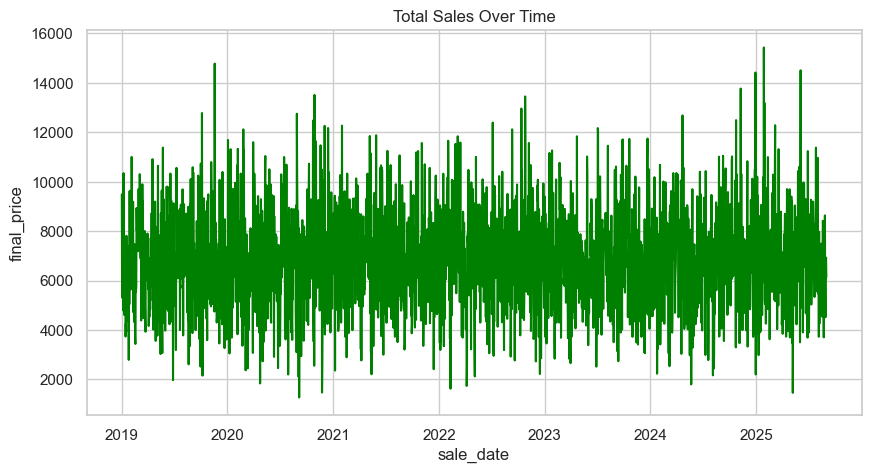

In [53]:
fact_sales['sale_date'] = pd.to_datetime(fact_sales['sale_date'])
sales_over_time = fact_sales.groupby('sale_date')['final_price'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=sales_over_time, x='sale_date', y='final_price', color='green')
plt.title("Total Sales Over Time")
plt.show()


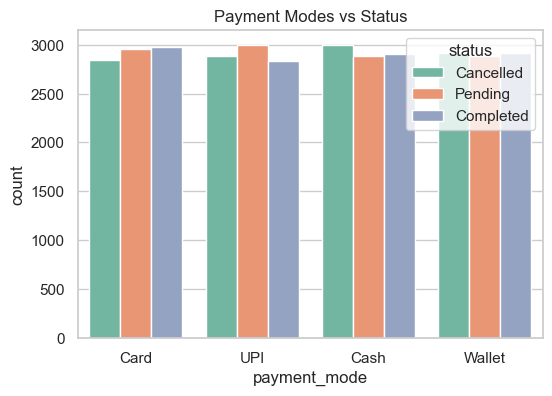

In [54]:
plt.figure(figsize=(6,4))
sns.countplot(data=fact_sales, x='payment_mode', hue='status', palette='Set2')
plt.title("Payment Modes vs Status")
plt.show()


### Customer Insights

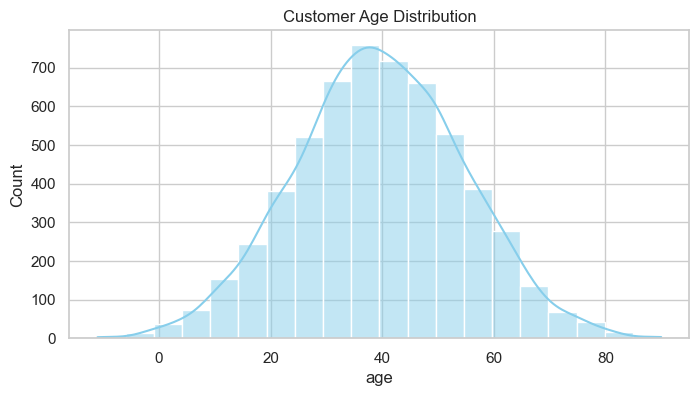

In [55]:
plt.figure(figsize=(8,4))
sns.histplot(dim_customer['age'], bins=20, kde=True, color='skyblue')
plt.title("Customer Age Distribution")
plt.show()


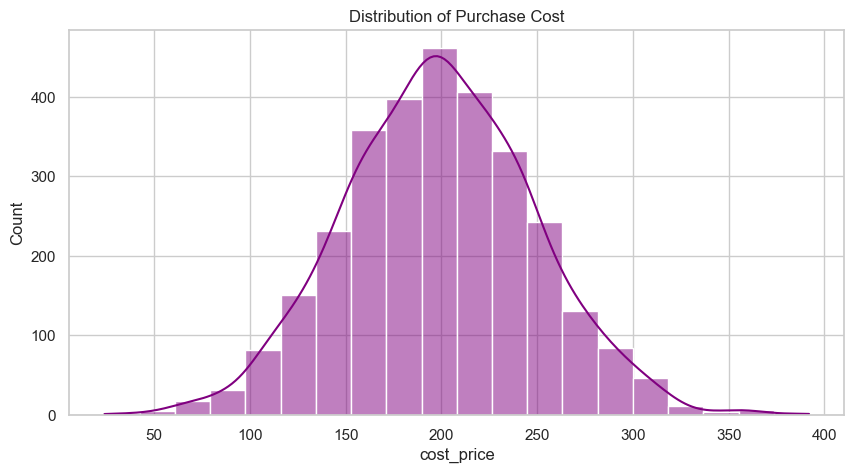

In [57]:
sns.histplot(purchases['cost_price'], bins=20, kde=True, color='purple')
plt.title("Distribution of Purchase Cost")
plt.show()

In [58]:
sup_qty = purchases.groupby('supplier_name')['quantity'].sum().reset_index()
fig = px.bar(sup_qty.sort_values('quantity', ascending=False),
             x='supplier_name', y='quantity', title='Quantity Purchased per Supplier')
fig.show()


In [59]:
fig = px.box(stocks, x='shop_id', y='available_units', title='Available Stock Units per Shop')
fig.show()


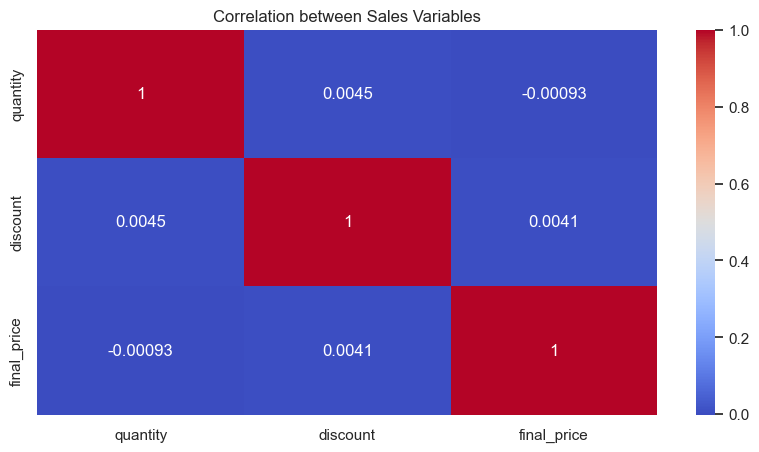

In [61]:
corr = sales_bills[['quantity', 'discount', 'final_price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Sales Variables")
plt.show()


In [64]:
doc_count = prescriptions['doctor_name'].value_counts().head(10).reset_index()
doc_count
fig = px.bar(doc_count, x='count', y='doctor_name', 
             title='Top 10 Doctors by Prescriptions',
             labels={'index':'Doctor','doctor_name':'Count'})
fig.show()


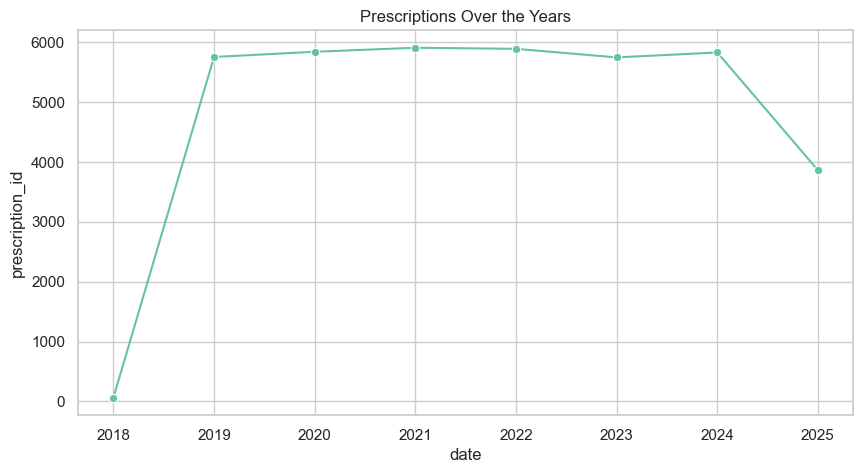

In [65]:
prescriptions['date'] = pd.to_datetime(prescriptions['date'])
presc_trend = prescriptions.groupby(prescriptions['date'].dt.year)['prescription_id'].count().reset_index()
sns.lineplot(data=presc_trend, x='date', y='prescription_id', marker='o')
plt.title("Prescriptions Over the Years")
plt.show()


In [67]:
fig = px.scatter(sales_bills, x='discount', y='final_price', color='payment_mode',
                 size='quantity', hover_data=['status'],
                 title='Discount vs Final Price by Payment Mode')
fig.show()


In [70]:
top_meds = sales_bills.groupby('medicine_id')['final_price'].sum().nlargest(10).reset_index()
top_meds = top_meds.merge(medicine[['medicine_id','medicine_name']], on='medicine_id')
fig = px.bar(top_meds, x='medicine_name', y='final_price', color='final_price',
             title='Top 10 Medicines by Revenue')
fig.show()


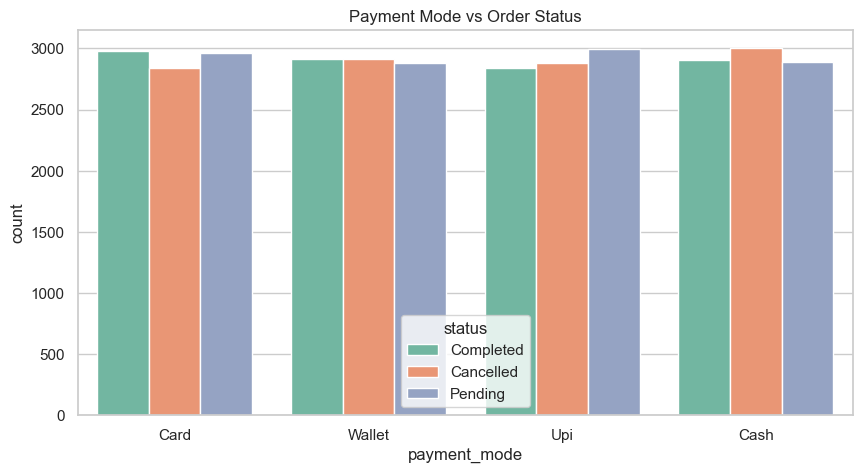

In [71]:
sns.countplot(data=sales_bills, x='payment_mode', hue='status')
plt.title("Payment Mode vs Order Status")
plt.show()


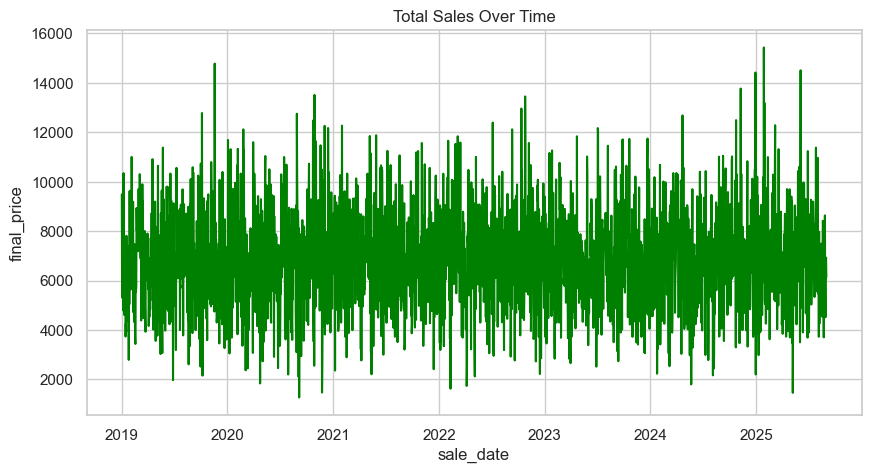

In [72]:
sales_bills['sale_date'] = pd.to_datetime(sales_bills['sale_date'])
sales_trend = sales_bills.groupby('sale_date')['final_price'].sum().reset_index()
sns.lineplot(data=sales_trend, x='sale_date', y='final_price', color='green')
plt.title("Total Sales Over Time")
plt.show()


In [73]:
fig = px.box(pharmacy, x='location', y='rating', color='location',
             title='Shop Ratings by Location')
fig.show()


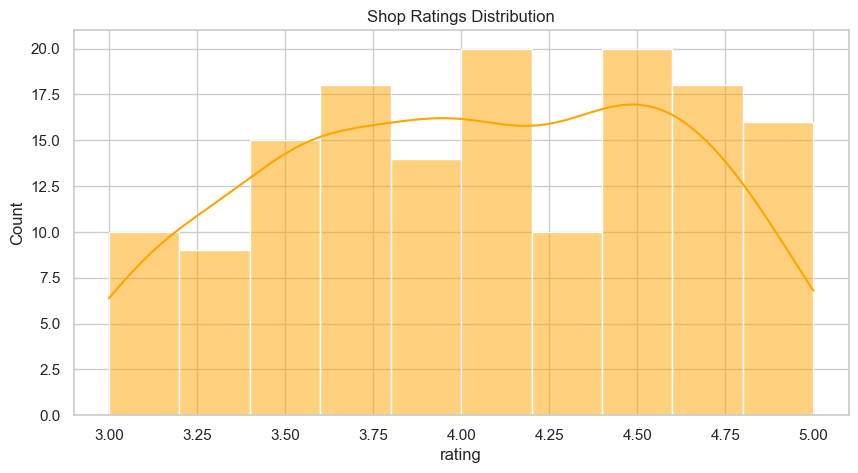

In [74]:
sns.histplot(pharmacy['rating'], bins=10, kde=True, color='orange')
plt.title("Shop Ratings Distribution")
plt.show()


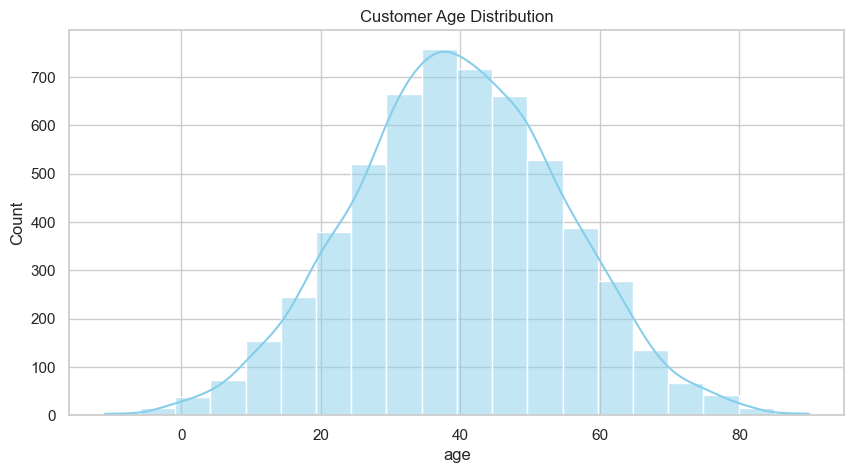

In [77]:
sns.histplot(customers['age'], bins=20, kde=True, color='skyblue')
plt.title("Customer Age Distribution")
plt.show()
